### Batch source extraction

This notebook shows how to run batch to extract sources in fits images of a directory-tree. <br>
* tptp
* tolto

In [43]:
import os , glob
import matplotlib.pyplot as plt
import sewpy


## directory
rootdir = "/home/stephane/Science/ETGs/RadioGalaxy/calibrators"
wdir    = "%s/products"%(rootdir)
plotdir = "%s/products/plots"%(rootdir)
fitsrootdir = "/home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary"

os.chdir(wdir)

In [44]:
## Get the list of all fits images assuming they have to be extracted.

def getFitsFiles(dir):
    list = glob.glob("%s/**/*fits"%(dir), recursive=True)
    
    return(list)

In [45]:
def runsextractor(image_file, detect_thresh=3.5, analysis_thresh=3.0):
    params = ['NUMBER', 'FLUX_ISO', 'FLUXERR_ISO', 'FLUX_AUTO', 'FLUXERR_AUTO', 'FLUX_BEST', 'FLUXERR_BEST', 'BACKGROUND', 
              'THRESHOLD', 'FLUX_MAX', 'XMAX_IMAGE', 'YMAX_IMAGE', 'XPEAK_IMAGE', 'YPEAK_IMAGE', 'ALPHAPEAK_J2000', 
              'DELTAPEAK_J2000', 'X_IMAGE', 'Y_IMAGE', 'ALPHA_SKY', 'DELTA_SKY', 'ALPHA_J2000', 'DELTA_J2000']

    config = {"DETECT_THRESH":detect_thresh, "ANALYSIS_THRESH":analysis_thresh}

    sew = sewpy.SEW(workdir="./", sexpath="/usr/bin/sextractor",params=params, config=config)

    out = sew(image_file)
    data = out["table"]
    
    ra, dec, flux, label = data['ALPHA_J2000'], data['DELTA_J2000'], data['FLUX_MAX'], data['NUMBER'].astype('int')
    
    return ra, dec, flux, label

In [46]:
## plots the sources...

def plotSources(plotdir, data):
    ra  = data['ra']
    dec = data['dec']
    flux = data['flux']
    
    plt.plot(ra,dec,"r*")
    plt.show()

In [47]:
def main(plot=True):
    lfits = getFitsFiles(fitsrootdir)
    
    res = []
    
    print("## Running sextractor...")
    for fitsimage in lfits:
        print("### Fits: %s"%(fitsimage))
        
        dat= {}
        ra, dec , flux , label = runsextractor(fitsimage)
        dat['fits'] = fitsimage
        dat['ra']   = ra
        dat['dec']  = dec
        dat['flux'] = flux
        
        res.append(dat)  
        
        if plot:
            plotSources(plotdir, dat)
       
    return(res)

Output catalog ./uid___A002_Xb09eed_X269f.ms.split.cal-CALIBRATE_PHASE-J1007-0207.ms.cont4.image.cat.txt already exists, I will overwrite it


## Running sextractor...
### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J1007-0207/Band4/uid___A002_Xb09eed_X269f.ms.split.cal-CALIBRATE_PHASE-J1007-0207.ms.cont4.image.fits


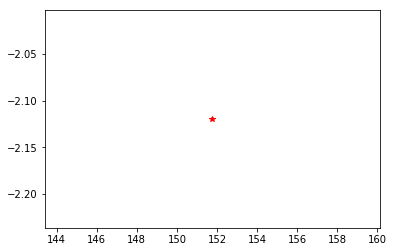

Output catalog ./uid___A002_Xb09eed_X269f.ms.split.cal-CALIBRATE_PHASE-J1007-0207.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J1007-0207/Band4/uid___A002_Xb09eed_X269f.ms.split.cal-CALIBRATE_PHASE-J1007-0207.ms.self3.substracted.cont.image.fits


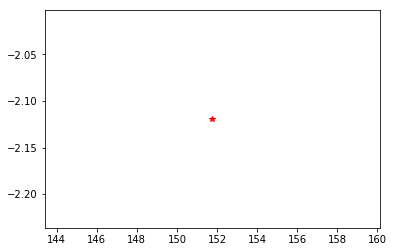

Output catalog ./uid___A002_Xb09eed_X1df8.ms.split.cal-CALIBRATE_PHASE-J1007-0207.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J1007-0207/Band4/uid___A002_Xb09eed_X1df8.ms.split.cal-CALIBRATE_PHASE-J1007-0207.ms.cont4.image.fits


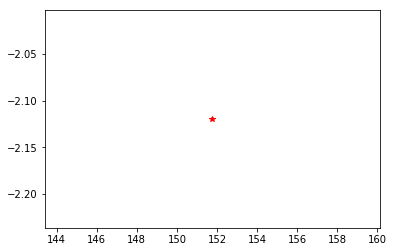

Output catalog ./uid___A002_Xb09eed_X1df8.ms.split.cal-CALIBRATE_PHASE-J1007-0207.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J1007-0207/Band4/uid___A002_Xb09eed_X1df8.ms.split.cal-CALIBRATE_PHASE-J1007-0207.ms.self3.substracted.cont.image.fits


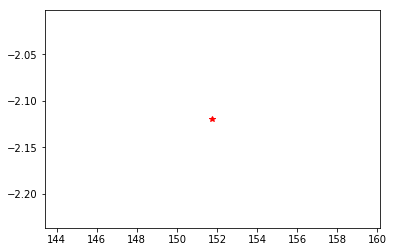

Output catalog ./uid___A002_X71a45c_X1d24.ms.split.cal-CALIBRATE_PHASE-J1007-0207.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J1007-0207/Band6/uid___A002_X71a45c_X1d24.ms.split.cal-CALIBRATE_PHASE-J1007-0207.ms.self3.substracted.cont.image.fits


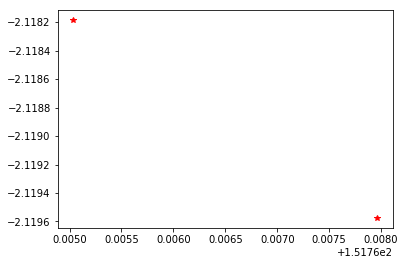

Output catalog ./uid___A002_X71a45c_X1d24.ms.split.cal-CALIBRATE_PHASE-J1007-0207.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J1007-0207/Band6/uid___A002_X71a45c_X1d24.ms.split.cal-CALIBRATE_PHASE-J1007-0207.ms.cont4.image.fits


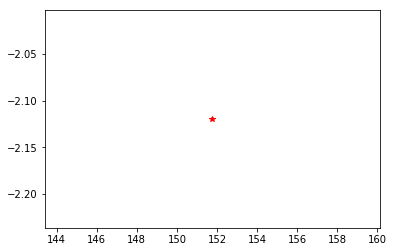

Output catalog ./uid___A002_X75ab74_Xf8d.ms.split.cal-CALIBRATE_PHASE-J1007-0207.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J1007-0207/Band7/uid___A002_X75ab74_Xf8d.ms.split.cal-CALIBRATE_PHASE-J1007-0207.ms.self3.substracted.cont.image.fits


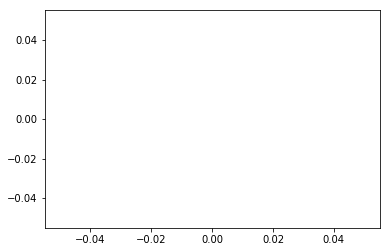

Output catalog ./uid___A002_X75ab74_Xf8d.ms.split.cal-CALIBRATE_PHASE-J1007-0207.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J1007-0207/Band7/uid___A002_X75ab74_Xf8d.ms.split.cal-CALIBRATE_PHASE-J1007-0207.ms.cont4.image.fits


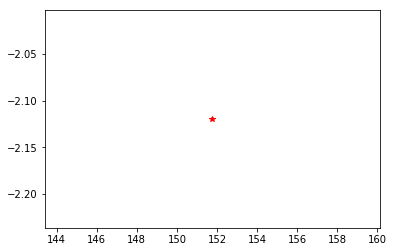

Output catalog ./uid___A002_Xb3b3c9_X147c.ms.split.cal-CALIBRATE_PHASE-J1007-0207.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J1007-0207/Band3/uid___A002_Xb3b3c9_X147c.ms.split.cal-CALIBRATE_PHASE-J1007-0207.ms.cont4.image.fits


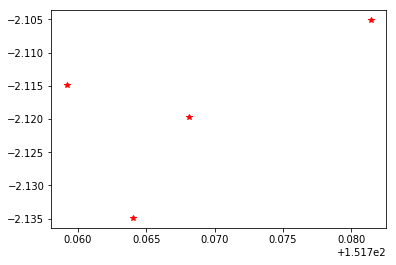

Output catalog ./uid___A002_Xb3b3c9_X147c.ms.split.cal-CALIBRATE_PHASE-J1007-0207.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J1007-0207/Band3/uid___A002_Xb3b3c9_X147c.ms.split.cal-CALIBRATE_PHASE-J1007-0207.ms.self3.substracted.cont.image.fits


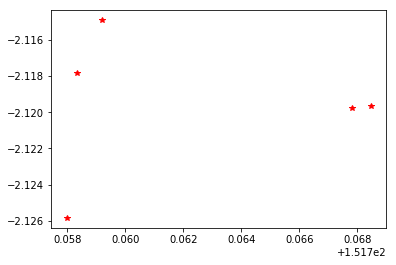

Output catalog ./uid___A002_Xb3ad79_Xe55.ms.split.cal-CALIBRATE_PHASE-J1007-0207.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J1007-0207/Band3/uid___A002_Xb3ad79_Xe55.ms.split.cal-CALIBRATE_PHASE-J1007-0207.ms.cont4.image.fits


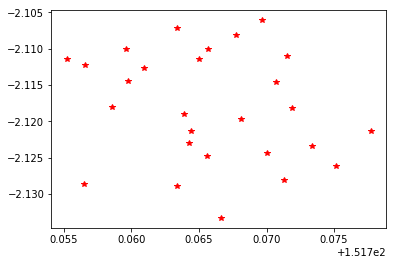

Output catalog ./uid___A002_Xb3ad79_Xe55.ms.split.cal-CALIBRATE_PHASE-J1007-0207.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J1007-0207/Band3/uid___A002_Xb3ad79_Xe55.ms.split.cal-CALIBRATE_PHASE-J1007-0207.ms.self3.substracted.cont.image.fits


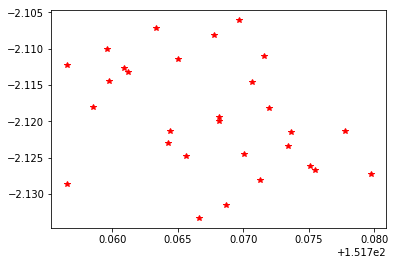

Output catalog ./uid___A002_Xb3e112_X1b95.ms.split.cal-CALIBRATE_PHASE-J2035+1056.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2035+1056/Band6/uid___A002_Xb3e112_X1b95.ms.split.cal-CALIBRATE_PHASE-J2035+1056.ms.self3.substracted.cont.image.fits


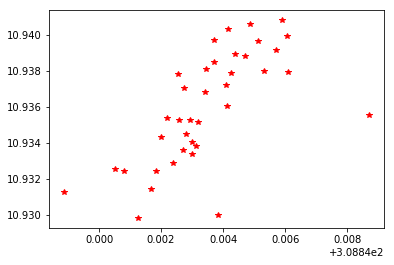

Output catalog ./uid___A002_Xb3e112_X1b95.ms.split.cal-CALIBRATE_PHASE-J2035+1056.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2035+1056/Band6/uid___A002_Xb3e112_X1b95.ms.split.cal-CALIBRATE_PHASE-J2035+1056.ms.cont4.image.fits


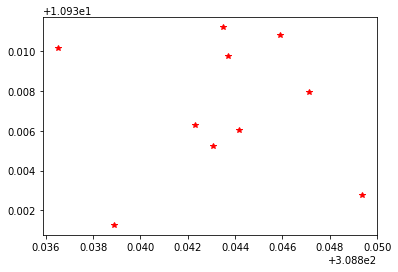

Output catalog ./uid___A002_Xb60831_X17.ms.split.cal-CALIBRATE_PHASE-J2035+1056.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2035+1056/Band7/uid___A002_Xb60831_X17.ms.split.cal-CALIBRATE_PHASE-J2035+1056.ms.cont4.image.fits


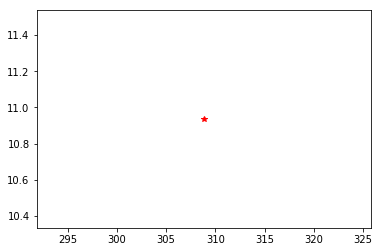

Output catalog ./uid___A002_Xb4f580_X52f1.ms.split.cal-CALIBRATE_PHASE-J2035+1056.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2035+1056/Band7/uid___A002_Xb4f580_X52f1.ms.split.cal-CALIBRATE_PHASE-J2035+1056.ms.cont4.image.fits


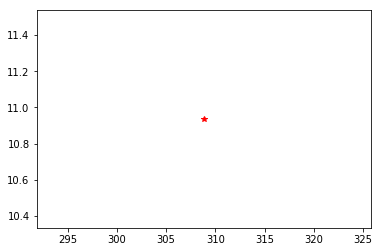

Output catalog ./uid___A002_Xb60831_X17.ms.split.cal-CALIBRATE_PHASE-J2035+1056.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2035+1056/Band7/uid___A002_Xb60831_X17.ms.split.cal-CALIBRATE_PHASE-J2035+1056.ms.self3.substracted.cont.image.fits


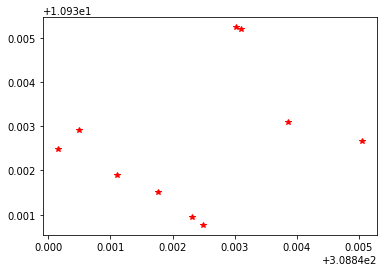

Output catalog ./uid___A002_Xb5aa7c_X4a6c.ms.split.cal-CALIBRATE_PHASE-J2035+1056.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2035+1056/Band7/uid___A002_Xb5aa7c_X4a6c.ms.split.cal-CALIBRATE_PHASE-J2035+1056.ms.self3.substracted.cont.image.fits


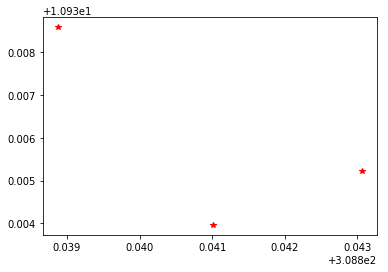

Output catalog ./uid___A002_Xb4f580_X52f1.ms.split.cal-CALIBRATE_PHASE-J2035+1056.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2035+1056/Band7/uid___A002_Xb4f580_X52f1.ms.split.cal-CALIBRATE_PHASE-J2035+1056.ms.self3.substracted.cont.image.fits


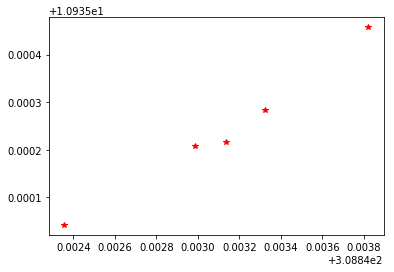

Output catalog ./uid___A002_Xb5aa7c_X4a6c.ms.split.cal-CALIBRATE_PHASE-J2035+1056.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2035+1056/Band7/uid___A002_Xb5aa7c_X4a6c.ms.split.cal-CALIBRATE_PHASE-J2035+1056.ms.cont4.image.fits


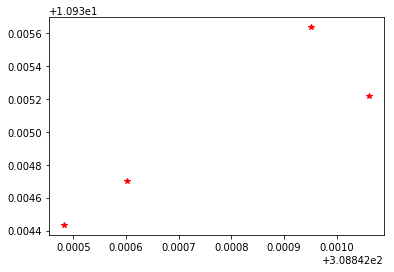

Output catalog ./uid___A002_Xb55f4e_X3d4.ms.split.cal-CALIBRATE_PHASE-J2035+1056.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2035+1056/Band3/uid___A002_Xb55f4e_X3d4.ms.split.cal-CALIBRATE_PHASE-J2035+1056.ms.self3.substracted.cont.image.fits


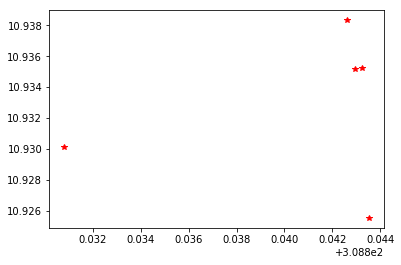

Output catalog ./uid___A002_Xb4f03d_X4b4.ms.split.cal-CALIBRATE_PHASE-J2035+1056.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2035+1056/Band3/uid___A002_Xb4f03d_X4b4.ms.split.cal-CALIBRATE_PHASE-J2035+1056.ms.cont4.image.fits


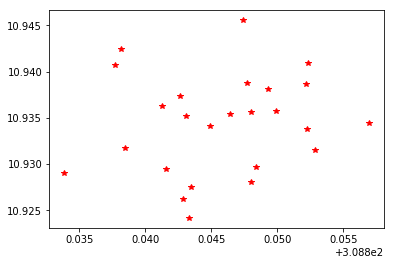

Output catalog ./uid___A002_Xb60831_X486.ms.split.cal-CALIBRATE_PHASE-J2035+1056.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2035+1056/Band3/uid___A002_Xb60831_X486.ms.split.cal-CALIBRATE_PHASE-J2035+1056.ms.cont4.image.fits


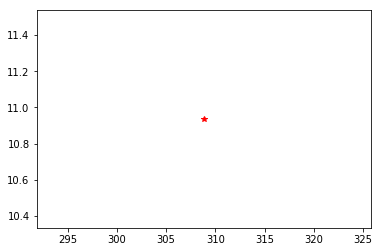

Output catalog ./uid___A002_Xb5aa7c_X4999.ms.split.cal-CALIBRATE_PHASE-J2035+1056.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2035+1056/Band3/uid___A002_Xb5aa7c_X4999.ms.split.cal-CALIBRATE_PHASE-J2035+1056.ms.self3.substracted.cont.image.fits


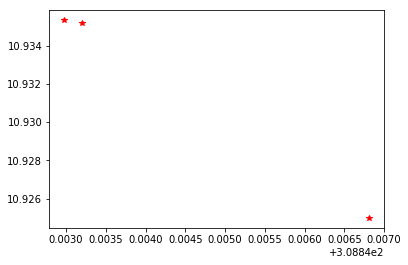

Output catalog ./uid___A002_Xb4f03d_X4b4.ms.split.cal-CALIBRATE_PHASE-J2035+1056.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2035+1056/Band3/uid___A002_Xb4f03d_X4b4.ms.split.cal-CALIBRATE_PHASE-J2035+1056.ms.self3.substracted.cont.image.fits


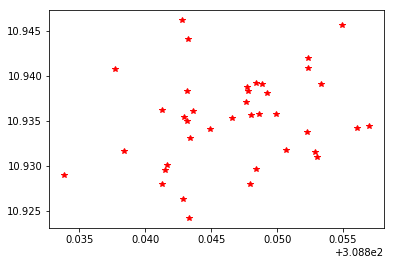

Output catalog ./uid___A002_Xb60831_X486.ms.split.cal-CALIBRATE_PHASE-J2035+1056.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2035+1056/Band3/uid___A002_Xb60831_X486.ms.split.cal-CALIBRATE_PHASE-J2035+1056.ms.self3.substracted.cont.image.fits


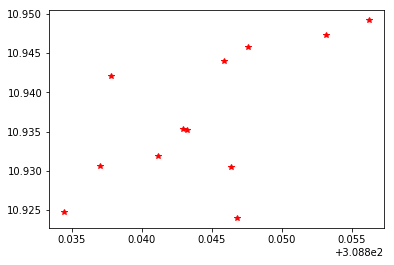

Output catalog ./uid___A002_Xb55f4e_X3d4.ms.split.cal-CALIBRATE_PHASE-J2035+1056.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2035+1056/Band3/uid___A002_Xb55f4e_X3d4.ms.split.cal-CALIBRATE_PHASE-J2035+1056.ms.cont4.image.fits


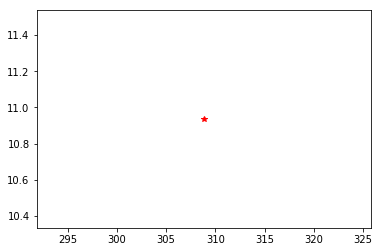

Output catalog ./uid___A002_Xb5aa7c_X4999.ms.split.cal-CALIBRATE_PHASE-J2035+1056.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2035+1056/Band3/uid___A002_Xb5aa7c_X4999.ms.split.cal-CALIBRATE_PHASE-J2035+1056.ms.cont4.image.fits


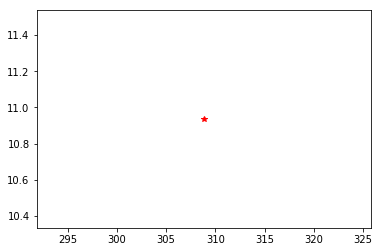

Output catalog ./uid___A002_Xaad35a_X154f.ms.split.cal-CALIBRATE_PHASE-J0040-3243.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0040-3243/Band6/uid___A002_Xaad35a_X154f.ms.split.cal-CALIBRATE_PHASE-J0040-3243.ms.self3.substracted.cont.image.fits


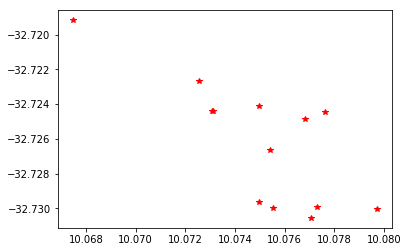

### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0040-3243/Band6/uid___A002_Xaad35a_X102a.ms.split.cal-CALIBRATE_PHASE-J0040-3243.ms.self3.substracted.cont.image.fits


Output catalog ./uid___A002_Xaad35a_X102a.ms.split.cal-CALIBRATE_PHASE-J0040-3243.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


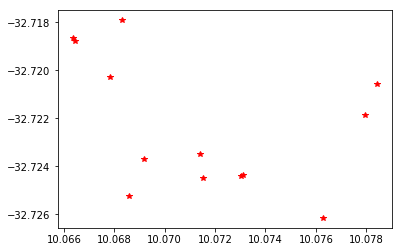

### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0040-3243/Band6/uid___A002_Xaad35a_X154f.ms.split.cal-CALIBRATE_PHASE-J0040-3243.ms.cont4.image.fits


Output catalog ./uid___A002_Xaad35a_X154f.ms.split.cal-CALIBRATE_PHASE-J0040-3243.ms.cont4.image.cat.txt already exists, I will overwrite it


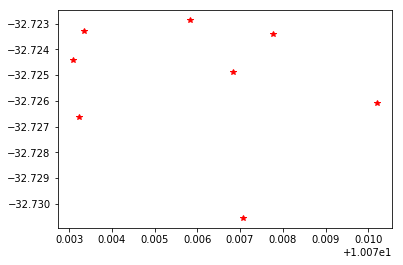

Output catalog ./uid___A002_Xaad35a_X102a.ms.split.cal-CALIBRATE_PHASE-J0040-3243.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0040-3243/Band6/uid___A002_Xaad35a_X102a.ms.split.cal-CALIBRATE_PHASE-J0040-3243.ms.cont4.image.fits


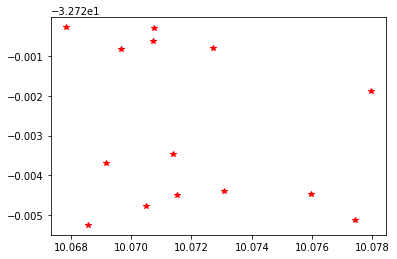

Output catalog ./uid___A002_Xb2b000_X23bf.ms.split.cal-CALIBRATE_PHASE-J0040-3243.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0040-3243/Band3/uid___A002_Xb2b000_X23bf.ms.split.cal-CALIBRATE_PHASE-J0040-3243.ms.self3.substracted.cont.image.fits


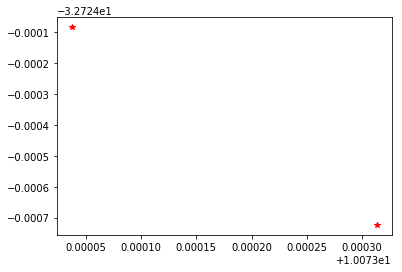

Output catalog ./uid___A002_Xb2b000_X23bf.ms.split.cal-CALIBRATE_PHASE-J0040-3243.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0040-3243/Band3/uid___A002_Xb2b000_X23bf.ms.split.cal-CALIBRATE_PHASE-J0040-3243.ms.cont4.image.fits


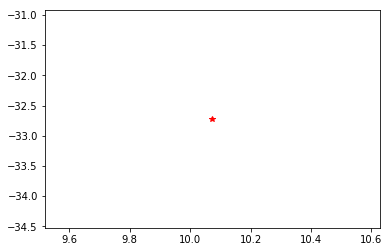

Output catalog ./uid___A002_Xa78e41_X13d5.ms.split.cal-CALIBRATE_PHASE-J0040-3243.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0040-3243/Band3/uid___A002_Xa78e41_X13d5.ms.split.cal-CALIBRATE_PHASE-J0040-3243.ms.self3.substracted.cont.image.fits


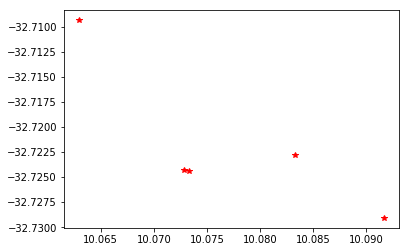

Output catalog ./uid___A002_Xa78e41_X13d5.ms.split.cal-CALIBRATE_PHASE-J0040-3243.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0040-3243/Band3/uid___A002_Xa78e41_X13d5.ms.split.cal-CALIBRATE_PHASE-J0040-3243.ms.cont4.image.fits


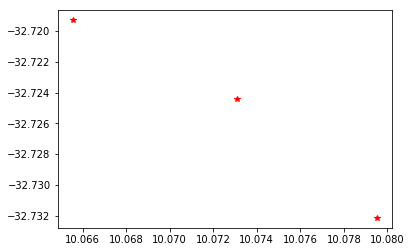

Output catalog ./uid___A002_Xb33b61_X2aa4.ms.split.cal-CALIBRATE_PHASE-J2056-5820.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2056-5820/Band6/uid___A002_Xb33b61_X2aa4.ms.split.cal-CALIBRATE_PHASE-J2056-5820.ms.self3.substracted.cont.image.fits


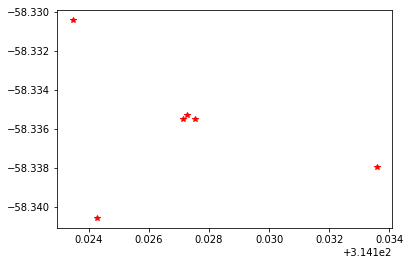

Output catalog ./uid___A002_Xb33b61_X2e66.ms.split.cal-CALIBRATE_PHASE-J2056-5820.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2056-5820/Band6/uid___A002_Xb33b61_X2e66.ms.split.cal-CALIBRATE_PHASE-J2056-5820.ms.cont4.image.fits


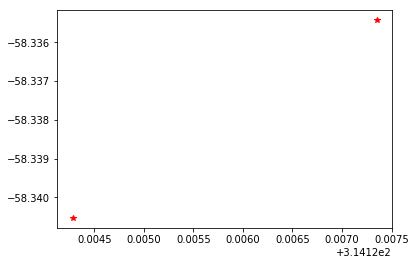

Output catalog ./uid___A002_Xb36550_X2e2e.ms.split.cal-CALIBRATE_PHASE-J2056-5820.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2056-5820/Band6/uid___A002_Xb36550_X2e2e.ms.split.cal-CALIBRATE_PHASE-J2056-5820.ms.cont4.image.fits


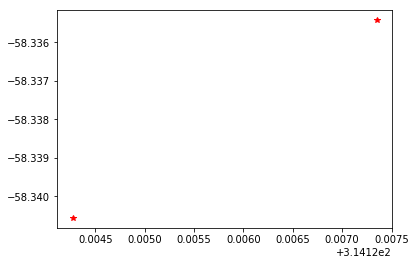

Output catalog ./uid___A002_Xb33b61_X2e66.ms.split.cal-CALIBRATE_PHASE-J2056-5820.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2056-5820/Band6/uid___A002_Xb33b61_X2e66.ms.split.cal-CALIBRATE_PHASE-J2056-5820.ms.self3.substracted.cont.image.fits


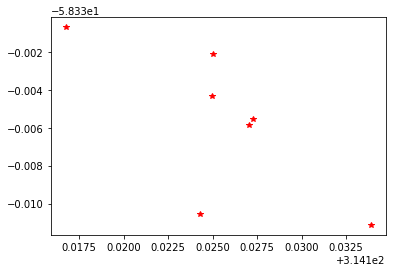

Output catalog ./uid___A002_Xb33b61_X2aa4.ms.split.cal-CALIBRATE_PHASE-J2056-5820.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2056-5820/Band6/uid___A002_Xb33b61_X2aa4.ms.split.cal-CALIBRATE_PHASE-J2056-5820.ms.cont4.image.fits


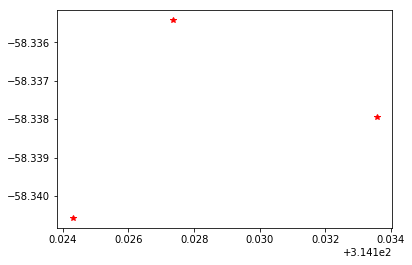

Output catalog ./uid___A002_Xb36550_X2e2e.ms.split.cal-CALIBRATE_PHASE-J2056-5820.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2056-5820/Band6/uid___A002_Xb36550_X2e2e.ms.split.cal-CALIBRATE_PHASE-J2056-5820.ms.self3.substracted.cont.image.fits


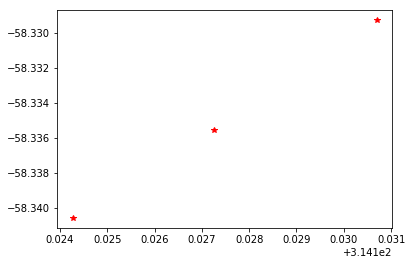

Output catalog ./uid___A002_Xb1cc39_X3edc.ms.split.cal-CALIBRATE_PHASE-J2056-5820.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2056-5820/Band7/uid___A002_Xb1cc39_X3edc.ms.split.cal-CALIBRATE_PHASE-J2056-5820.ms.self3.substracted.cont.image.fits


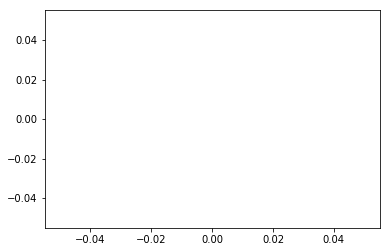

Output catalog ./uid___A002_Xb1cc39_X3edc.ms.split.cal-CALIBRATE_PHASE-J2056-5820.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2056-5820/Band7/uid___A002_Xb1cc39_X3edc.ms.split.cal-CALIBRATE_PHASE-J2056-5820.ms.cont4.image.fits


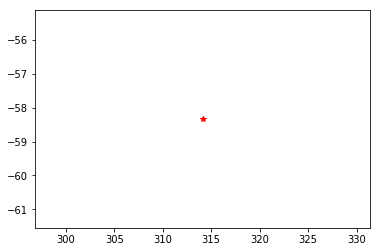

Output catalog ./uid___A002_Xb7a3f8_X9915.ms.split.cal-CALIBRATE_PHASE-J2056-5820.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2056-5820/Band3/uid___A002_Xb7a3f8_X9915.ms.split.cal-CALIBRATE_PHASE-J2056-5820.ms.self3.substracted.cont.image.fits


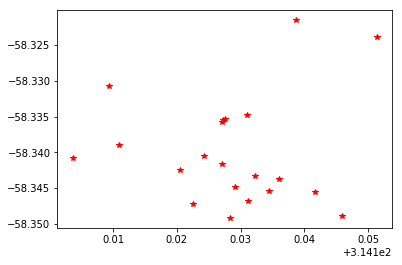

Output catalog ./uid___A002_Xb1e6b5_X4a00.ms.split.cal-CALIBRATE_PHASE-J2056-5820.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2056-5820/Band3/uid___A002_Xb1e6b5_X4a00.ms.split.cal-CALIBRATE_PHASE-J2056-5820.ms.cont4.image.fits


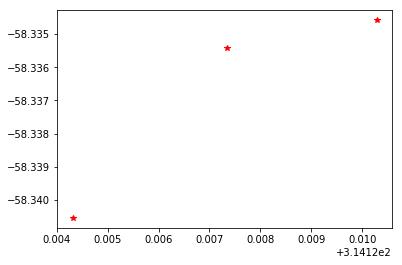

Output catalog ./uid___A002_Xb7a3f8_X9915.ms.split.cal-CALIBRATE_PHASE-J2056-5820.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2056-5820/Band3/uid___A002_Xb7a3f8_X9915.ms.split.cal-CALIBRATE_PHASE-J2056-5820.ms.cont4.image.fits


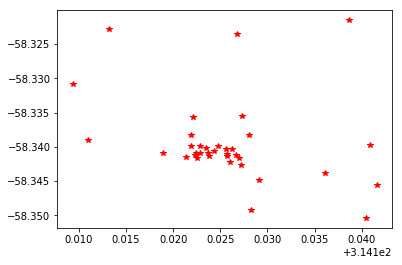

Output catalog ./uid___A002_Xb6a8c1_Xa7bd.ms.split.cal-CALIBRATE_PHASE-J2056-5820.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2056-5820/Band3/uid___A002_Xb6a8c1_Xa7bd.ms.split.cal-CALIBRATE_PHASE-J2056-5820.ms.cont4.image.fits


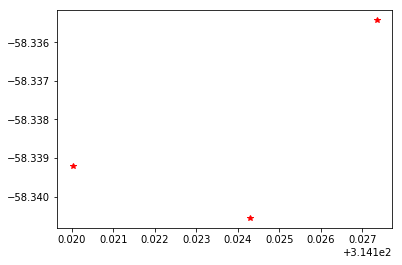

Output catalog ./uid___A002_Xb5e334_X301b.ms.split.cal-CALIBRATE_PHASE-J2056-5820.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2056-5820/Band3/uid___A002_Xb5e334_X301b.ms.split.cal-CALIBRATE_PHASE-J2056-5820.ms.self3.substracted.cont.image.fits


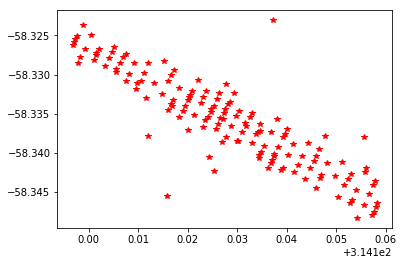

Output catalog ./uid___A002_Xaf2188_X213a.ms.split.cal-CALIBRATE_PHASE-J2056-5820.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2056-5820/Band3/uid___A002_Xaf2188_X213a.ms.split.cal-CALIBRATE_PHASE-J2056-5820.ms.self3.substracted.cont.image.fits


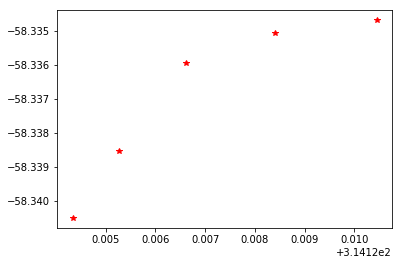

Output catalog ./uid___A002_Xb1e6b5_X4a00.ms.split.cal-CALIBRATE_PHASE-J2056-5820.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2056-5820/Band3/uid___A002_Xb1e6b5_X4a00.ms.split.cal-CALIBRATE_PHASE-J2056-5820.ms.self3.substracted.cont.image.fits


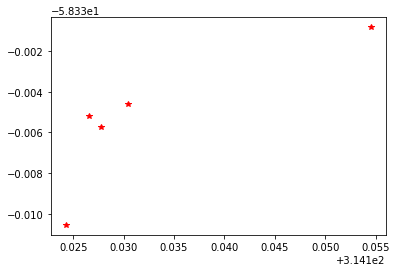

Output catalog ./uid___A002_Xb5e334_X301b.ms.split.cal-CALIBRATE_PHASE-J2056-5820.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2056-5820/Band3/uid___A002_Xb5e334_X301b.ms.split.cal-CALIBRATE_PHASE-J2056-5820.ms.cont4.image.fits


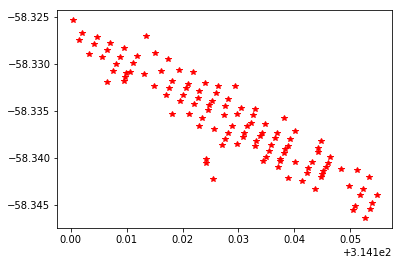

Output catalog ./uid___A002_Xb5ee5a_X1451.ms.split.cal-CALIBRATE_PHASE-J2056-5820.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2056-5820/Band3/uid___A002_Xb5ee5a_X1451.ms.split.cal-CALIBRATE_PHASE-J2056-5820.ms.self3.substracted.cont.image.fits


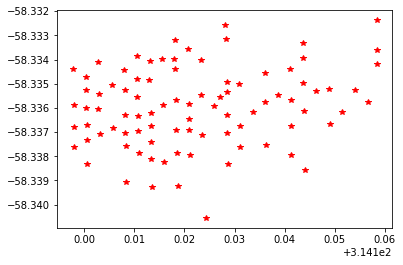

Output catalog ./uid___A002_Xb5ee5a_X1451.ms.split.cal-CALIBRATE_PHASE-J2056-5820.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2056-5820/Band3/uid___A002_Xb5ee5a_X1451.ms.split.cal-CALIBRATE_PHASE-J2056-5820.ms.cont4.image.fits


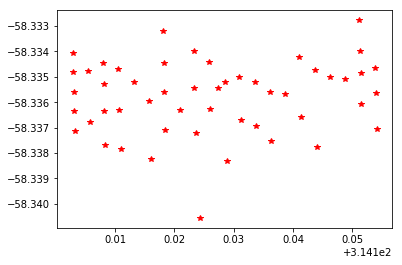

Output catalog ./uid___A002_Xaebbcb_X29e3.ms.split.cal-CALIBRATE_PHASE-J2056-5820.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2056-5820/Band3/uid___A002_Xaebbcb_X29e3.ms.split.cal-CALIBRATE_PHASE-J2056-5820.ms.cont4.image.fits


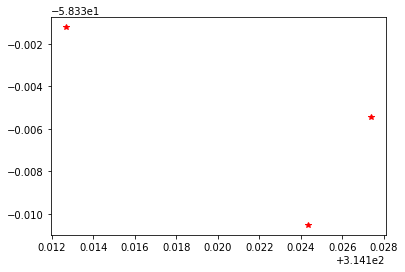

Output catalog ./uid___A002_Xb6a8c1_Xa7bd.ms.split.cal-CALIBRATE_PHASE-J2056-5820.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2056-5820/Band3/uid___A002_Xb6a8c1_Xa7bd.ms.split.cal-CALIBRATE_PHASE-J2056-5820.ms.self3.substracted.cont.image.fits


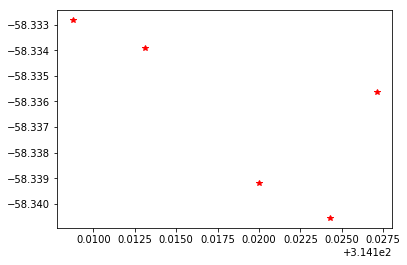

Output catalog ./uid___A002_Xaf2188_X213a.ms.split.cal-CALIBRATE_PHASE-J2056-5820.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2056-5820/Band3/uid___A002_Xaf2188_X213a.ms.split.cal-CALIBRATE_PHASE-J2056-5820.ms.cont4.image.fits


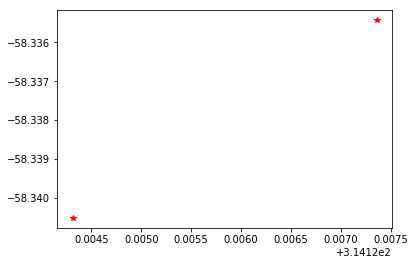

Output catalog ./uid___A002_Xaebbcb_X29e3.ms.split.cal-CALIBRATE_PHASE-J2056-5820.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2056-5820/Band3/uid___A002_Xaebbcb_X29e3.ms.split.cal-CALIBRATE_PHASE-J2056-5820.ms.self3.substracted.cont.image.fits


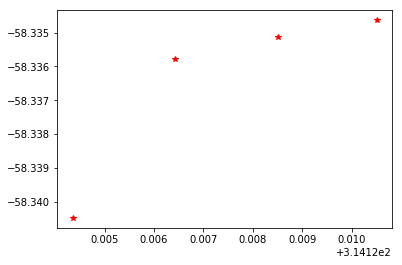

Output catalog ./uid___A002_Xb55f4e_X36b4.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0811-4929/Band4/uid___A002_Xb55f4e_X36b4.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.fits


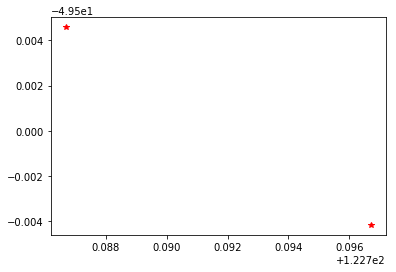

Output catalog ./uid___A002_Xb55f4e_X36b4.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0811-4929/Band4/uid___A002_Xb55f4e_X36b4.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.self3.substracted.cont.image.fits


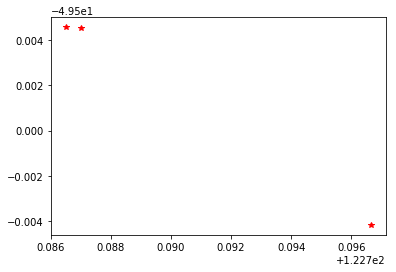

Output catalog ./uid___A002_Xb57286_X1130.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0811-4929/Band8/uid___A002_Xb57286_X1130.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.fits


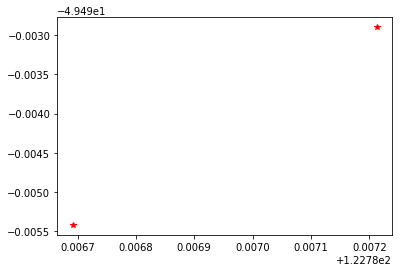

Output catalog ./uid___A002_Xb57286_X1130.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0811-4929/Band8/uid___A002_Xb57286_X1130.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.self3.substracted.cont.image.fits


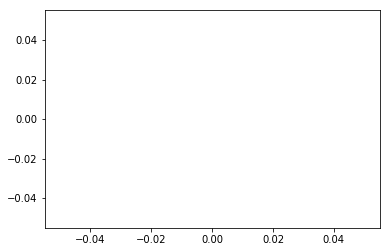

Output catalog ./uid___A002_Xb52d1b_X403.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0811-4929/Band8/uid___A002_Xb52d1b_X403.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.self3.substracted.cont.image.fits


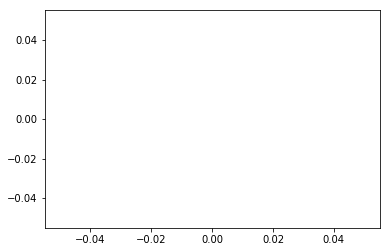

Output catalog ./uid___A002_Xb52d1b_X403.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0811-4929/Band8/uid___A002_Xb52d1b_X403.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.fits


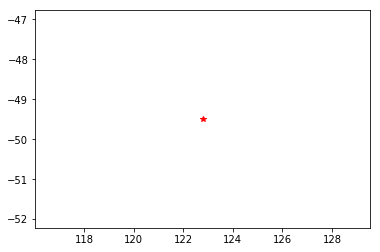

Output catalog ./uid___A002_Xba4d35_Xca1b.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0811-4929/Band8/uid___A002_Xba4d35_Xca1b.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.fits


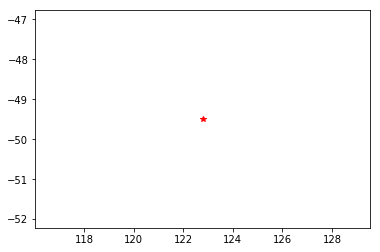

Output catalog ./uid___A002_Xba4d35_Xca1b.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0811-4929/Band8/uid___A002_Xba4d35_Xca1b.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.self3.substracted.cont.image.fits


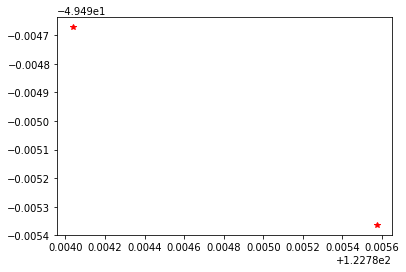

Output catalog ./uid___A002_Xb52d1b_Xf5f.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0811-4929/Band6/uid___A002_Xb52d1b_Xf5f.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.fits


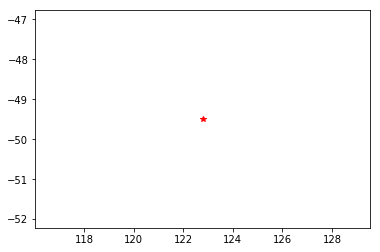

Output catalog ./uid___A002_Xc3c940_X18d2.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0811-4929/Band6/uid___A002_Xc3c940_X18d2.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.fits


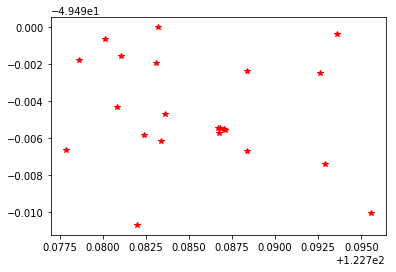

Output catalog ./uid___A002_Xb499c3_X626f.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0811-4929/Band6/uid___A002_Xb499c3_X626f.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.fits


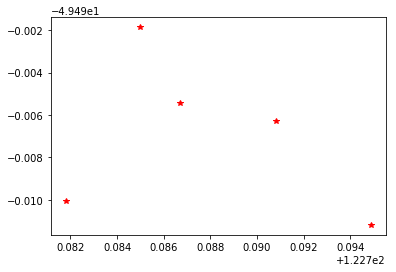

Output catalog ./uid___A002_Xb1e6b5_X1b44.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0811-4929/Band6/uid___A002_Xb1e6b5_X1b44.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.fits


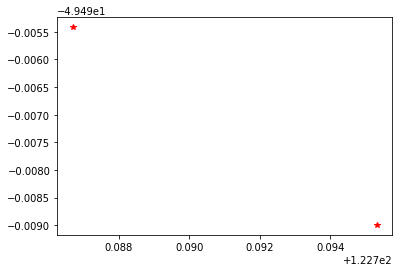

Output catalog ./uid___A002_Xb52d1b_Xf5f.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0811-4929/Band6/uid___A002_Xb52d1b_Xf5f.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.self3.substracted.cont.image.fits


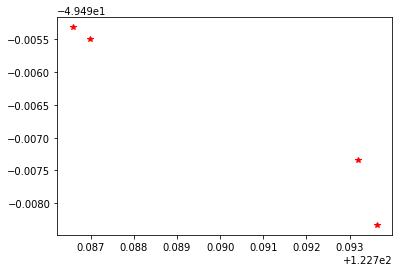

Output catalog ./uid___A002_Xb4f580_X385f.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0811-4929/Band6/uid___A002_Xb4f580_X385f.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.self3.substracted.cont.image.fits


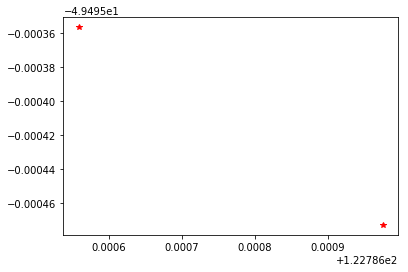

Output catalog ./uid___A002_Xb4f580_X385f.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0811-4929/Band6/uid___A002_Xb4f580_X385f.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.fits


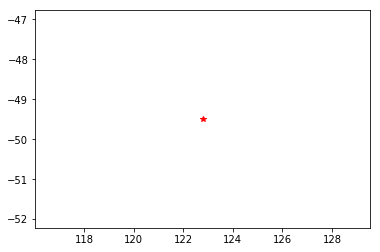

Output catalog ./uid___A002_Xb499c3_X626f.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0811-4929/Band6/uid___A002_Xb499c3_X626f.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.self3.substracted.cont.image.fits


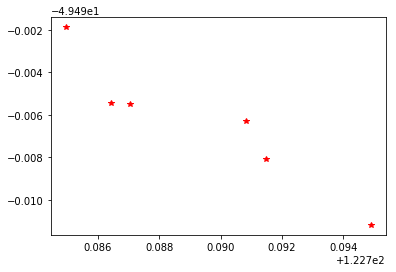

Output catalog ./uid___A002_Xb1e6b5_X1b44.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0811-4929/Band6/uid___A002_Xb1e6b5_X1b44.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.self3.substracted.cont.image.fits


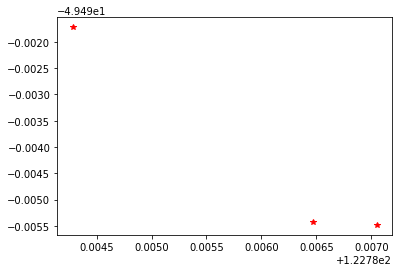

Output catalog ./uid___A002_Xc3c940_X18d2.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0811-4929/Band6/uid___A002_Xc3c940_X18d2.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.self3.substracted.cont.image.fits


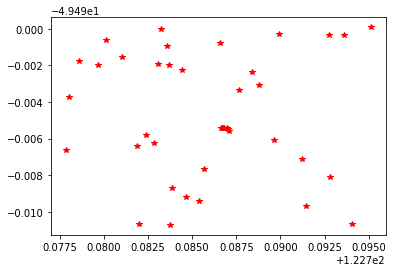

Output catalog ./uid___A002_Xb0ebd1_Xba16.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0811-4929/Band7/uid___A002_Xb0ebd1_Xba16.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.fits


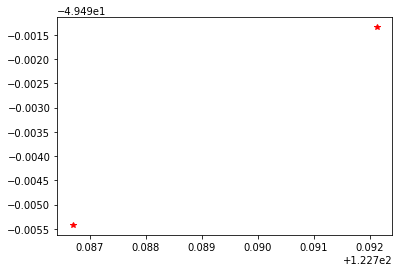

Output catalog ./uid___A002_Xb0ebd1_Xba16.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0811-4929/Band7/uid___A002_Xb0ebd1_Xba16.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.self3.substracted.cont.image.fits


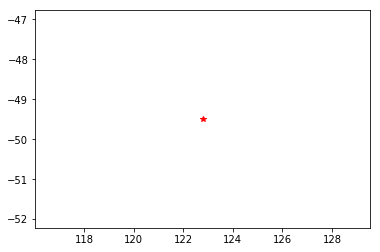

Output catalog ./uid___A002_Xb0ebd1_X1d3b.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0811-4929/Band7/uid___A002_Xb0ebd1_X1d3b.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.fits


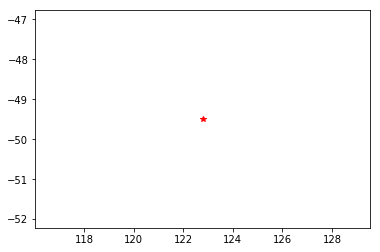

Output catalog ./uid___A002_Xb05734_X632.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0811-4929/Band7/uid___A002_Xb05734_X632.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.self3.substracted.cont.image.fits


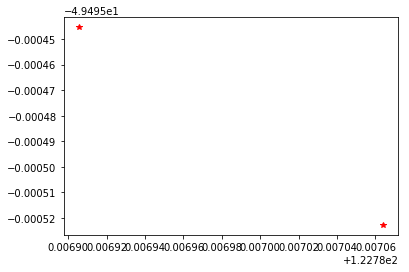

Output catalog ./uid___A002_Xb05734_X632.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0811-4929/Band7/uid___A002_Xb05734_X632.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.fits


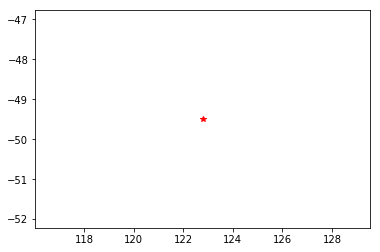

Output catalog ./uid___A002_Xb0ebd1_X1d3b.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0811-4929/Band7/uid___A002_Xb0ebd1_X1d3b.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.self3.substracted.cont.image.fits


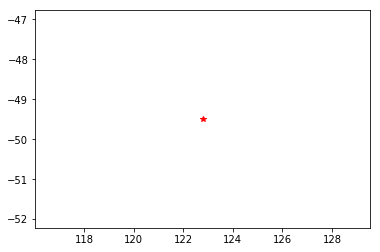

Output catalog ./uid___A002_Xb5bd46_X55ee.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0811-4929/Band3/uid___A002_Xb5bd46_X55ee.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.self3.substracted.cont.image.fits


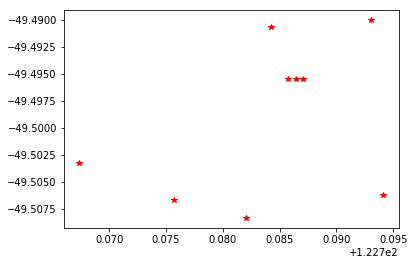

### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0811-4929/Band3/uid___A002_Xb5bd46_X55ee.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.fits


Output catalog ./uid___A002_Xb5bd46_X55ee.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.cat.txt already exists, I will overwrite it


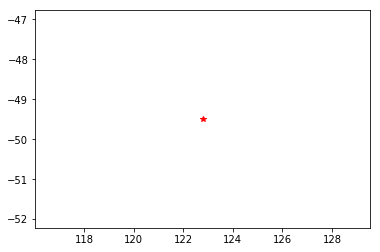

Output catalog ./uid___A002_Xb55f4e_X38bf.ms.split.cal-CALIBRATE_PHASE-J1038+0512.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J1038+0512/Band4/uid___A002_Xb55f4e_X38bf.ms.split.cal-CALIBRATE_PHASE-J1038+0512.ms.self3.substracted.cont.image.fits


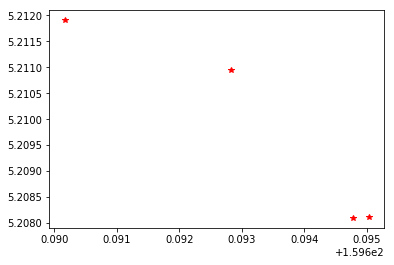

Output catalog ./uid___A002_Xb55f4e_X3b32.ms.split.cal-CALIBRATE_PHASE-J1038+0512.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J1038+0512/Band4/uid___A002_Xb55f4e_X3b32.ms.split.cal-CALIBRATE_PHASE-J1038+0512.ms.cont4.image.fits


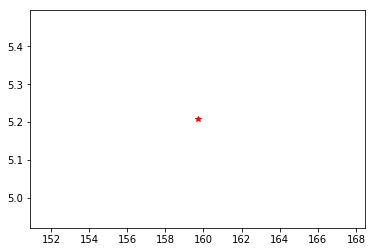

Output catalog ./uid___A002_Xb55f4e_X3b32.ms.split.cal-CALIBRATE_PHASE-J1038+0512.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J1038+0512/Band4/uid___A002_Xb55f4e_X3b32.ms.split.cal-CALIBRATE_PHASE-J1038+0512.ms.self3.substracted.cont.image.fits


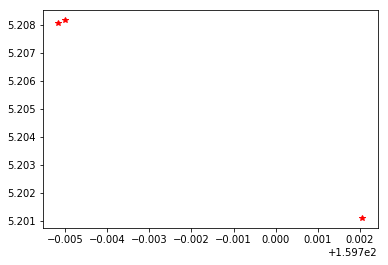

Output catalog ./uid___A002_Xb55f4e_X38bf.ms.split.cal-CALIBRATE_PHASE-J1038+0512.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J1038+0512/Band4/uid___A002_Xb55f4e_X38bf.ms.split.cal-CALIBRATE_PHASE-J1038+0512.ms.cont4.image.fits


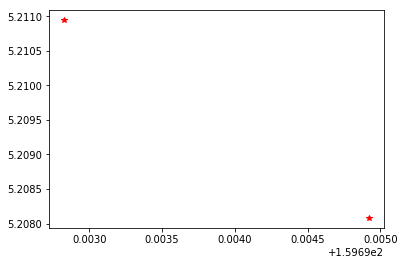

Output catalog ./uid___A002_Xaf985b_X4e6.ms.split.cal-CALIBRATE_PHASE-J1038+0512.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J1038+0512/Band6/uid___A002_Xaf985b_X4e6.ms.split.cal-CALIBRATE_PHASE-J1038+0512.ms.self3.substracted.cont.image.fits


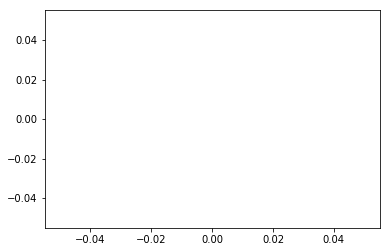

Output catalog ./uid___A002_Xaf985b_X4e6.ms.split.cal-CALIBRATE_PHASE-J1038+0512.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J1038+0512/Band6/uid___A002_Xaf985b_X4e6.ms.split.cal-CALIBRATE_PHASE-J1038+0512.ms.cont4.image.fits


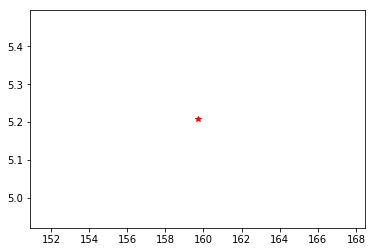

Output catalog ./uid___A002_Xb499c3_Xba59.ms.split.cal-CALIBRATE_PHASE-J1038+0512.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J1038+0512/Band7/uid___A002_Xb499c3_Xba59.ms.split.cal-CALIBRATE_PHASE-J1038+0512.ms.cont4.image.fits


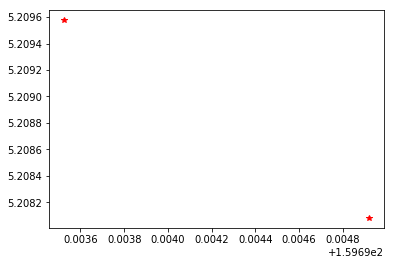

Output catalog ./uid___A002_Xba4d35_Xd492.ms.split.cal-CALIBRATE_PHASE-J1038+0512.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J1038+0512/Band7/uid___A002_Xba4d35_Xd492.ms.split.cal-CALIBRATE_PHASE-J1038+0512.ms.self3.substracted.cont.image.fits


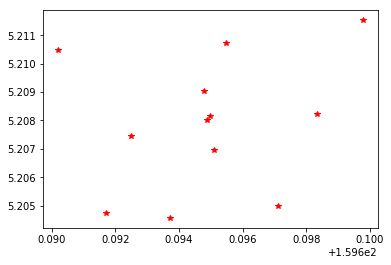

Output catalog ./uid___A002_Xba4d35_Xd492.ms.split.cal-CALIBRATE_PHASE-J1038+0512.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J1038+0512/Band7/uid___A002_Xba4d35_Xd492.ms.split.cal-CALIBRATE_PHASE-J1038+0512.ms.cont4.image.fits


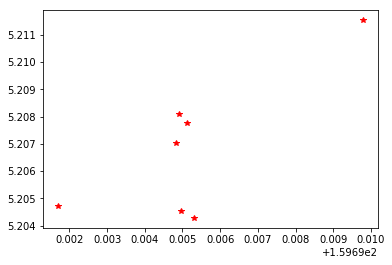

Output catalog ./uid___A002_Xb499c3_Xba59.ms.split.cal-CALIBRATE_PHASE-J1038+0512.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J1038+0512/Band7/uid___A002_Xb499c3_Xba59.ms.split.cal-CALIBRATE_PHASE-J1038+0512.ms.self3.substracted.cont.image.fits


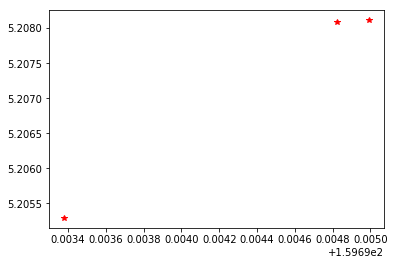

Output catalog ./uid___A002_Xba839d_X483e.ms.split.cal-CALIBRATE_PHASE-J1038+0512.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J1038+0512/Band7/uid___A002_Xba839d_X483e.ms.split.cal-CALIBRATE_PHASE-J1038+0512.ms.self3.substracted.cont.image.fits


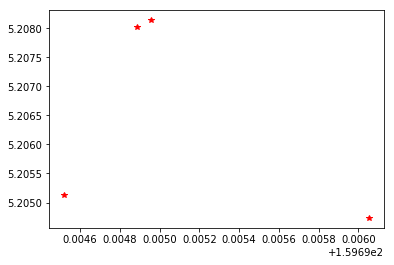

Output catalog ./uid___A002_Xba839d_X483e.ms.split.cal-CALIBRATE_PHASE-J1038+0512.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J1038+0512/Band7/uid___A002_Xba839d_X483e.ms.split.cal-CALIBRATE_PHASE-J1038+0512.ms.cont4.image.fits


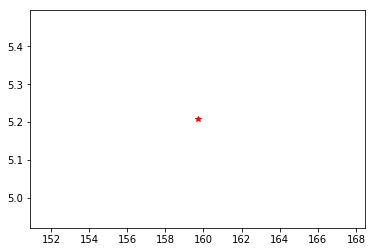

Output catalog ./uid___A002_X98124f_X2127.ms.split.cal-CALIBRATE_PHASE-J1315-5334.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J1315-5334/Band6/uid___A002_X98124f_X2127.ms.split.cal-CALIBRATE_PHASE-J1315-5334.ms.self3.substracted.cont.image.fits


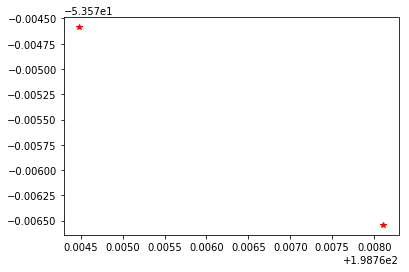

Output catalog ./uid___A002_Xb7d0ee_Xcc9d.ms.split.cal-CALIBRATE_PHASE-J1315-5334.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J1315-5334/Band6/uid___A002_Xb7d0ee_Xcc9d.ms.split.cal-CALIBRATE_PHASE-J1315-5334.ms.self3.substracted.cont.image.fits


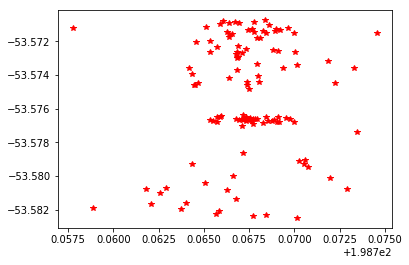

Output catalog ./uid___A002_X98124f_X2127.ms.split.cal-CALIBRATE_PHASE-J1315-5334.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J1315-5334/Band6/uid___A002_X98124f_X2127.ms.split.cal-CALIBRATE_PHASE-J1315-5334.ms.cont4.image.fits


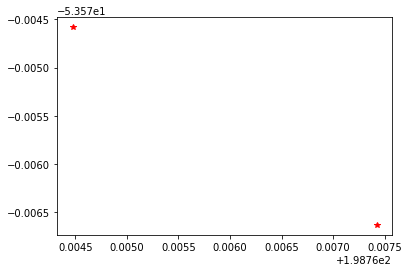

Output catalog ./uid___A002_Xb7d0ee_Xcc9d.ms.split.cal-CALIBRATE_PHASE-J1315-5334.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J1315-5334/Band6/uid___A002_Xb7d0ee_Xcc9d.ms.split.cal-CALIBRATE_PHASE-J1315-5334.ms.cont4.image.fits


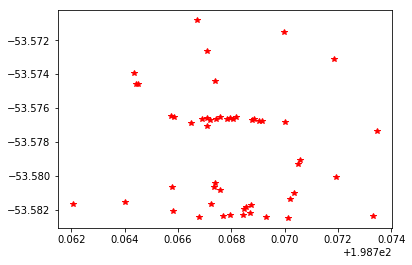

Output catalog ./uid___A002_Xb7d0ee_X516a.ms.split.cal-CALIBRATE_PHASE-J1315-5334.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J1315-5334/Band3/uid___A002_Xb7d0ee_X516a.ms.split.cal-CALIBRATE_PHASE-J1315-5334.ms.self3.substracted.cont.image.fits


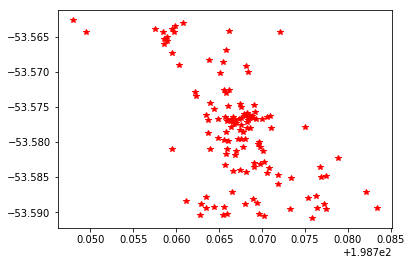

Output catalog ./uid___A002_Xb7d0ee_X516a.ms.split.cal-CALIBRATE_PHASE-J1315-5334.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J1315-5334/Band3/uid___A002_Xb7d0ee_X516a.ms.split.cal-CALIBRATE_PHASE-J1315-5334.ms.cont4.image.fits


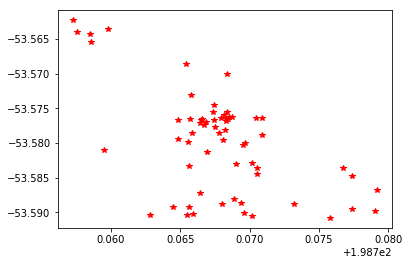

Output catalog ./uid___A002_Xb74a0f_X2b72.ms.split.cal-CALIBRATE_PHASE-J1315-5334.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J1315-5334/Band3/uid___A002_Xb74a0f_X2b72.ms.split.cal-CALIBRATE_PHASE-J1315-5334.ms.cont4.image.fits


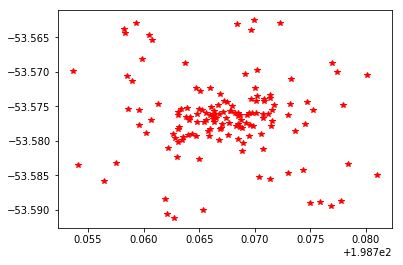

Output catalog ./uid___A002_Xb74a0f_X2b72.ms.split.cal-CALIBRATE_PHASE-J1315-5334.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J1315-5334/Band3/uid___A002_Xb74a0f_X2b72.ms.split.cal-CALIBRATE_PHASE-J1315-5334.ms.self3.substracted.cont.image.fits


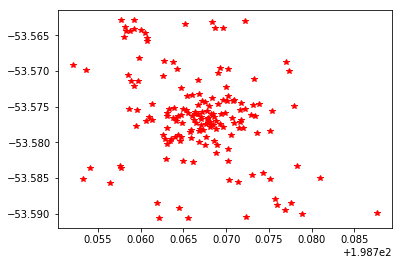

Output catalog ./uid___A002_Xb499c3_Xadd0.ms.split.cal-CALIBRATE_PHASE-J0531-4827.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0531-4827/Band6/uid___A002_Xb499c3_Xadd0.ms.split.cal-CALIBRATE_PHASE-J0531-4827.ms.cont4.image.fits


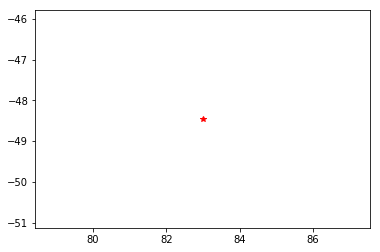

Output catalog ./uid___A002_Xb499c3_Xadd0.ms.split.cal-CALIBRATE_PHASE-J0531-4827.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0531-4827/Band6/uid___A002_Xb499c3_Xadd0.ms.split.cal-CALIBRATE_PHASE-J0531-4827.ms.self3.substracted.cont.image.fits


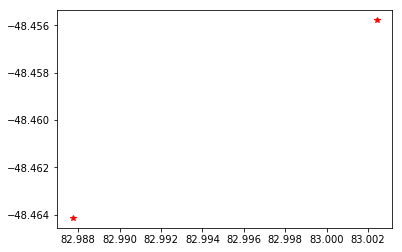

Output catalog ./uid___A002_Xb499c3_Xb108.ms.split.cal-CALIBRATE_PHASE-J0531-4827.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0531-4827/Band6/uid___A002_Xb499c3_Xb108.ms.split.cal-CALIBRATE_PHASE-J0531-4827.ms.self3.substracted.cont.image.fits


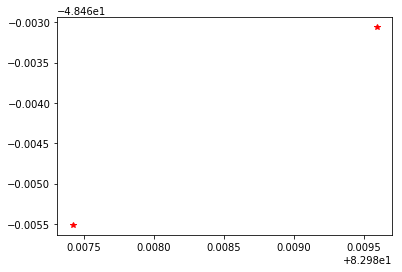

Output catalog ./uid___A002_Xb499c3_Xb108.ms.split.cal-CALIBRATE_PHASE-J0531-4827.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0531-4827/Band6/uid___A002_Xb499c3_Xb108.ms.split.cal-CALIBRATE_PHASE-J0531-4827.ms.cont4.image.fits


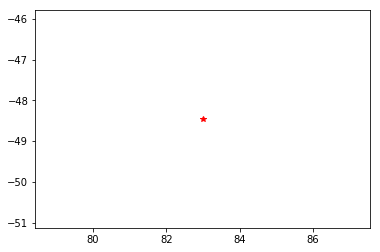

Output catalog ./uid___A002_Xbc9c9e_X14ee.ms.split.cal-CALIBRATE_PHASE-J0531-4827.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0531-4827/Band3/uid___A002_Xbc9c9e_X14ee.ms.split.cal-CALIBRATE_PHASE-J0531-4827.ms.cont4.image.fits


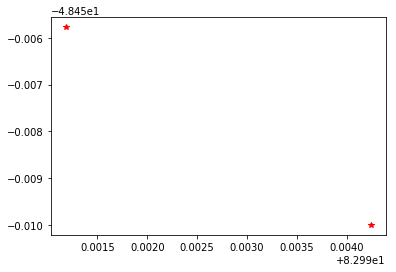

Output catalog ./uid___A002_Xbc9c9e_X14ee.ms.split.cal-CALIBRATE_PHASE-J0531-4827.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0531-4827/Band3/uid___A002_Xbc9c9e_X14ee.ms.split.cal-CALIBRATE_PHASE-J0531-4827.ms.self3.substracted.cont.image.fits


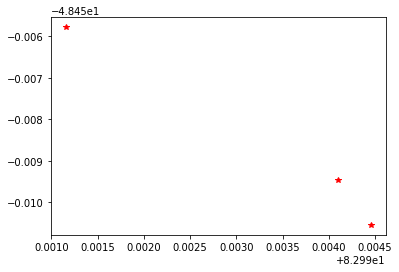

Output catalog ./uid___A002_Xbc9c9e_X1593.ms.split.cal-CALIBRATE_PHASE-J0531-4827.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0531-4827/Band3/uid___A002_Xbc9c9e_X1593.ms.split.cal-CALIBRATE_PHASE-J0531-4827.ms.self3.substracted.cont.image.fits


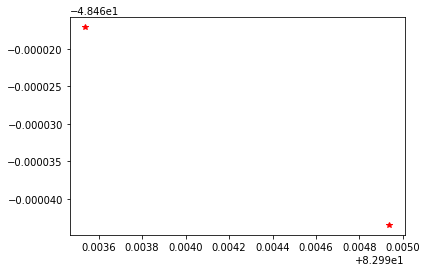

Output catalog ./uid___A002_Xbc9c9e_X1593.ms.split.cal-CALIBRATE_PHASE-J0531-4827.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0531-4827/Band3/uid___A002_Xbc9c9e_X1593.ms.split.cal-CALIBRATE_PHASE-J0531-4827.ms.cont4.image.fits


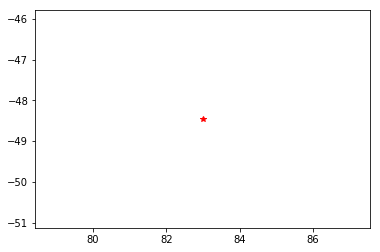

Output catalog ./uid___A002_Xa7dc73_X2319.ms.split.cal-CALIBRATE_PHASE-J0340-2119.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0340-2119/Band6/uid___A002_Xa7dc73_X2319.ms.split.cal-CALIBRATE_PHASE-J0340-2119.ms.cont4.image.fits


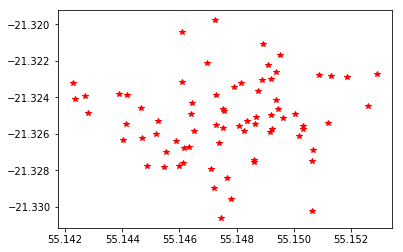

Output catalog ./uid___A002_Xbb30f0_X1d33.ms.split.cal-CALIBRATE_PHASE-J0340-2119.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0340-2119/Band6/uid___A002_Xbb30f0_X1d33.ms.split.cal-CALIBRATE_PHASE-J0340-2119.ms.self3.substracted.cont.image.fits


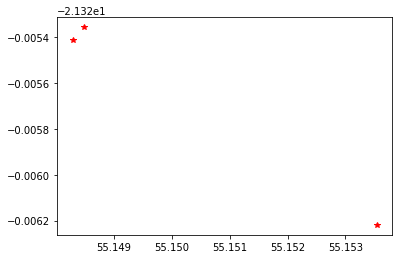

Output catalog ./uid___A002_Xbb30f0_X1d33.ms.split.cal-CALIBRATE_PHASE-J0340-2119.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0340-2119/Band6/uid___A002_Xbb30f0_X1d33.ms.split.cal-CALIBRATE_PHASE-J0340-2119.ms.cont4.image.fits


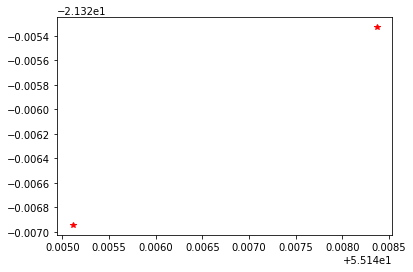

Output catalog ./uid___A002_Xa7dc73_X2319.ms.split.cal-CALIBRATE_PHASE-J0340-2119.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0340-2119/Band6/uid___A002_Xa7dc73_X2319.ms.split.cal-CALIBRATE_PHASE-J0340-2119.ms.self3.substracted.cont.image.fits


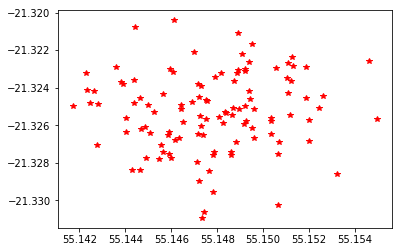

Output catalog ./uid___A002_X8917e8_X516.ms.split.cal-CALIBRATE_PHASE-J0340-2119.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0340-2119/Band7/uid___A002_X8917e8_X516.ms.split.cal-CALIBRATE_PHASE-J0340-2119.ms.cont4.image.fits


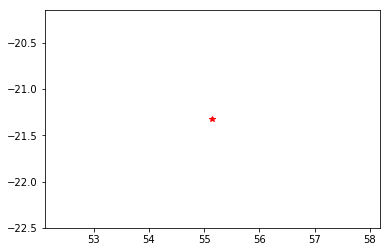

Output catalog ./uid___A002_X8917e8_X516.ms.split.cal-CALIBRATE_PHASE-J0340-2119.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0340-2119/Band7/uid___A002_X8917e8_X516.ms.split.cal-CALIBRATE_PHASE-J0340-2119.ms.self3.substracted.cont.image.fits


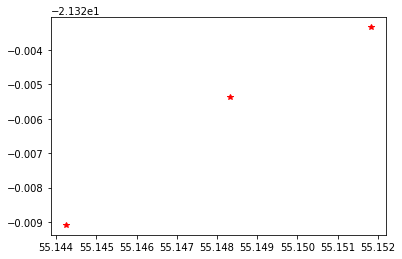

Output catalog ./uid___A002_Xa789ca_X259.ms.split.cal-CALIBRATE_PHASE-J0340-2119.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0340-2119/Band3/uid___A002_Xa789ca_X259.ms.split.cal-CALIBRATE_PHASE-J0340-2119.ms.cont4.image.fits


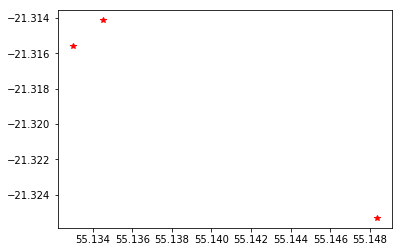

Output catalog ./uid___A002_Xb28642_X7fd8.ms.split.cal-CALIBRATE_PHASE-J0340-2119.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0340-2119/Band3/uid___A002_Xb28642_X7fd8.ms.split.cal-CALIBRATE_PHASE-J0340-2119.ms.cont4.image.fits


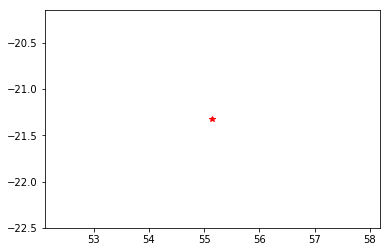

Output catalog ./uid___A002_Xa789ca_X259.ms.split.cal-CALIBRATE_PHASE-J0340-2119.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0340-2119/Band3/uid___A002_Xa789ca_X259.ms.split.cal-CALIBRATE_PHASE-J0340-2119.ms.self3.substracted.cont.image.fits


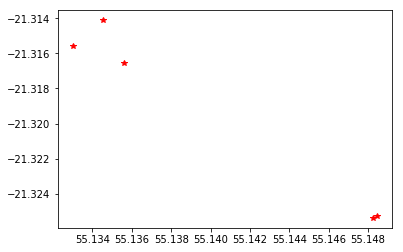

Output catalog ./uid___A002_Xb28642_X7fd8.ms.split.cal-CALIBRATE_PHASE-J0340-2119.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0340-2119/Band3/uid___A002_Xb28642_X7fd8.ms.split.cal-CALIBRATE_PHASE-J0340-2119.ms.self3.substracted.cont.image.fits


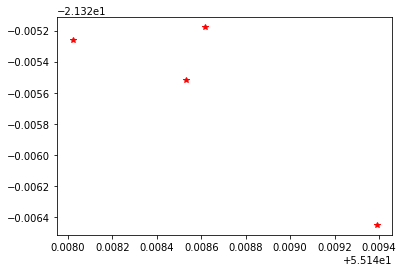

Output catalog ./uid___A002_Xa6c1df_X1062.ms.split.cal-CALIBRATE_PHASE-J2158-1501.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2158-1501/Band9/uid___A002_Xa6c1df_X1062.ms.split.cal-CALIBRATE_PHASE-J2158-1501.ms.cont4.image.fits


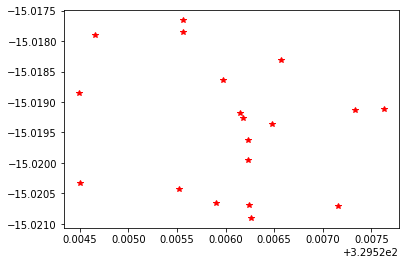

Output catalog ./uid___A002_Xa45c3f_X1611.ms.split.cal-CALIBRATE_PHASE-J2158-1501.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2158-1501/Band9/uid___A002_Xa45c3f_X1611.ms.split.cal-CALIBRATE_PHASE-J2158-1501.ms.self3.substracted.cont.image.fits


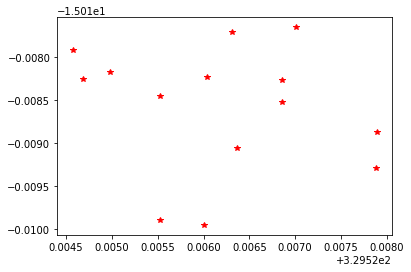

Output catalog ./uid___A002_X9fa4e2_X3680.ms.split.cal-CALIBRATE_PHASE-J2158-1501.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2158-1501/Band9/uid___A002_X9fa4e2_X3680.ms.split.cal-CALIBRATE_PHASE-J2158-1501.ms.self3.substracted.cont.image.fits


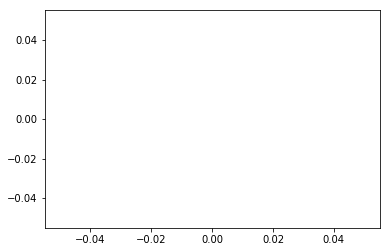

Output catalog ./uid___A002_X9fa4e2_X3084.ms.split.cal-CALIBRATE_PHASE-J2158-1501.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2158-1501/Band9/uid___A002_X9fa4e2_X3084.ms.split.cal-CALIBRATE_PHASE-J2158-1501.ms.self3.substracted.cont.image.fits


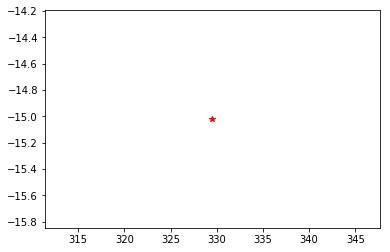

Output catalog ./uid___A002_X9fa4e2_X3680.ms.split.cal-CALIBRATE_PHASE-J2158-1501.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2158-1501/Band9/uid___A002_X9fa4e2_X3680.ms.split.cal-CALIBRATE_PHASE-J2158-1501.ms.cont4.image.fits


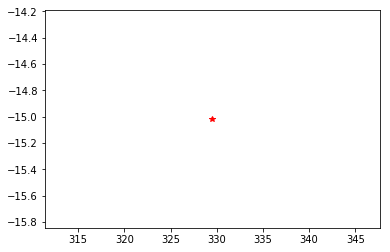

Output catalog ./uid___A002_Xa45c3f_X1611.ms.split.cal-CALIBRATE_PHASE-J2158-1501.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2158-1501/Band9/uid___A002_Xa45c3f_X1611.ms.split.cal-CALIBRATE_PHASE-J2158-1501.ms.cont4.image.fits


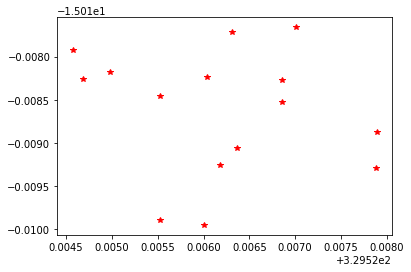

Output catalog ./uid___A002_Xa6c1df_X1062.ms.split.cal-CALIBRATE_PHASE-J2158-1501.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2158-1501/Band9/uid___A002_Xa6c1df_X1062.ms.split.cal-CALIBRATE_PHASE-J2158-1501.ms.self3.substracted.cont.image.fits


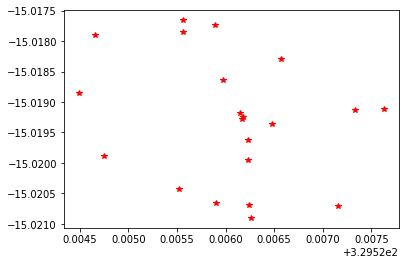

### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2158-1501/Band9/uid___A002_X9fa4e2_X3084.ms.split.cal-CALIBRATE_PHASE-J2158-1501.ms.cont4.image.fits


Output catalog ./uid___A002_X9fa4e2_X3084.ms.split.cal-CALIBRATE_PHASE-J2158-1501.ms.cont4.image.cat.txt already exists, I will overwrite it


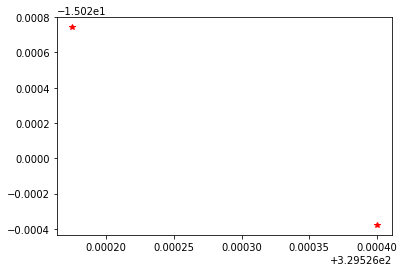

Output catalog ./uid___A002_Xaa8932_X2ac2.ms.split.cal-CALIBRATE_PHASE-J2158-1501.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2158-1501/Band6/uid___A002_Xaa8932_X2ac2.ms.split.cal-CALIBRATE_PHASE-J2158-1501.ms.cont4.image.fits


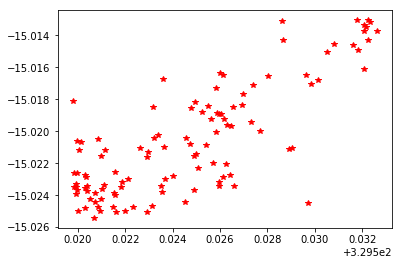

Output catalog ./uid___A002_Xaa8932_X2ac2.ms.split.cal-CALIBRATE_PHASE-J2158-1501.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2158-1501/Band6/uid___A002_Xaa8932_X2ac2.ms.split.cal-CALIBRATE_PHASE-J2158-1501.ms.self3.substracted.cont.image.fits


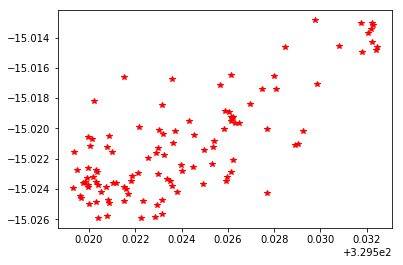

Output catalog ./uid___A002_Xa916fc_X13d7.ms.split.cal-CALIBRATE_BANDPASS-J2158-1501.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2158-1501/Band7/uid___A002_Xa916fc_X13d7.ms.split.cal-CALIBRATE_BANDPASS-J2158-1501.ms.cont4.image.fits


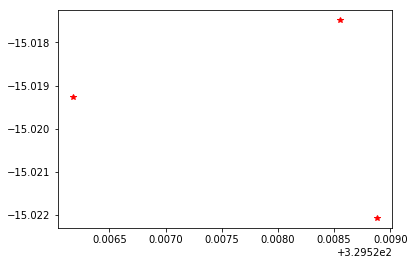

Output catalog ./uid___A002_Xa7f9e3_X210.ms.split.cal-CALIBRATE_BANDPASS-J2158-1501.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2158-1501/Band7/uid___A002_Xa7f9e3_X210.ms.split.cal-CALIBRATE_BANDPASS-J2158-1501.ms.cont4.image.fits


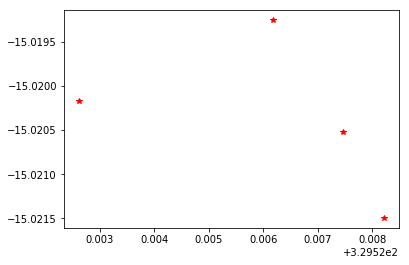

Output catalog ./uid___A002_Xa7f9e3_X210.ms.split.cal-CALIBRATE_BANDPASS-J2158-1501.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2158-1501/Band7/uid___A002_Xa7f9e3_X210.ms.split.cal-CALIBRATE_BANDPASS-J2158-1501.ms.self3.substracted.cont.image.fits


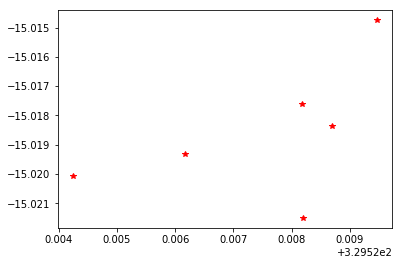

Output catalog ./uid___A002_Xa916fc_X13d7.ms.split.cal-CALIBRATE_BANDPASS-J2158-1501.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2158-1501/Band7/uid___A002_Xa916fc_X13d7.ms.split.cal-CALIBRATE_BANDPASS-J2158-1501.ms.self3.substracted.cont.image.fits


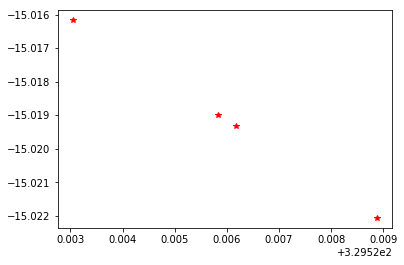

Output catalog ./uid___A002_Xa9a44e_X1225.ms.split.cal-CALIBRATE_BANDPASS-J2158-1501.ms.self3.substracted.cont.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2158-1501/Band3/uid___A002_Xa9a44e_X1225.ms.split.cal-CALIBRATE_BANDPASS-J2158-1501.ms.self3.substracted.cont.image.fits


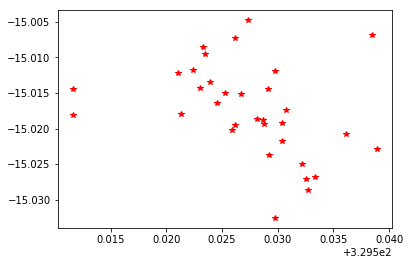

Output catalog ./uid___A002_Xa9a44e_X1225.ms.split.cal-CALIBRATE_BANDPASS-J2158-1501.ms.cont4.image.cat.txt already exists, I will overwrite it


### Fits: /home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J2158-1501/Band3/uid___A002_Xa9a44e_X1225.ms.split.cal-CALIBRATE_BANDPASS-J2158-1501.ms.cont4.image.fits


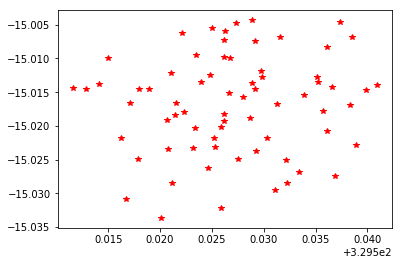

In [48]:
allres = main()

# im = "/home/stephane/Science/ETGs/RadioGalaxy/calibrators/ALMA/analysis/bosscha/tertiary/J0040-3243/Band3/uid___A002_Xa78e41_X13d5.ms.split.cal-CALIBRATE_PHASE-J0040-3243.ms.cont4.image.fits"
# print(runsextractor(im))